# Author: Elvis Ilunga  





### Contents  

**Introduction**  
**Part I**
1. **Libraries of Interest**  
2. **Preliminaries - Read and Varify the Data**  
3. **Data**  
4. **Exploratory Data Analysis**  
   4.1. **Visualise Target Variable**  
5. **Logistic Regression Model Fitting**   
   5.1. **Training Model**   
   5.2. **Model Predictions**   
   5.3. **Confusion Matrix**  
   5.4. **Interpretation**  
6. **ROC Curve**  
   6.1. **AUC**  
**Part II**
1. **Likelihood Calculation**  




## Introduction    

The case consists in predicting the likelihood of a client not taking up a policy. We are going to fit a predictive model that predicts this likelihood and show how good is this model or its predictive power.   

In the second stance we are required to understanding and calculate the likelihood of a client who made his first monthly payment and could carry on paying six months without lapsing or canceling the contract.     

The data to solve the case study consists of the details of insurance clients who typically sign a contract to pay monthly insurance premiums.   
If they make the first months’ premium payment the contract is regarded as taken up and active   

Among all the variables, three of them are highlighted as follows:   

* Take up outcome: this indicates if the client made first payment and therefore the policy is classified as taken up if the first payment was made.  

* Contract status: indicates if the policy is still active (1 = Active and the client is still paying the monthly premium, 0 = Cancelled or lapsed and the client is not paying premiums anymore)   

* Collection Count: counts the number of monthly premiums received on the specific policy at the data extraction date.   


Note:   

     - if the contract was never taken up, it means the first premium was never paid and the number of collections would
       reflect as zero.   
     – the collection count would stop at the date when the last payment was received, so for policies that are not active
       any more, this would reflect the total number of payments received before they cancelled/lapsed.   


## Part I

### 1. Libraries of Interest

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

###  2. Preliminaries- Read and Verify the Data

In [2]:
#Read in the data
original_data = pd.read_csv('Sample_data.csv')

In [3]:
#Make a copy of the original data in case of accidental modification
clients_data = original_data

In [4]:
#Let's take a look at the dimensions (number of rows and columns) of the dataset and the name of the variables
print(clients_data.shape)
print(clients_data.columns)

(25499, 23)
Index(['Policy Number', 'Policy Status', 'Age', 'Gender', 'Home Language',
       'Family Status', 'Gross Household Income', 'Gross Income',
       'Monthly Premium Original', 'Monthly Premium',
       'Dfference between Household and Personal Income', 'Salary Day',
       'Debit order day', 'Education', 'Occupation', 'Province', 'Postal Code',
       'Policy Affordability %', 'Policy Affordability % Band',
       'Response Outcome', 'Take Up Outcome', 'Contract Status',
       'Collection Count'],
      dtype='object')


In [5]:
#A quick look at the first five observations
clients_data.head()

,Policy Number,Policy Status,Age,Gender,Home Language,Family Status,Gross Household Income,Gross Income,Monthly Premium Original,Monthly Premium,...,Education,Occupation,Province,Postal Code,Policy Affordability %,Policy Affordability % Band,Response Outcome,Take Up Outcome,Contract Status,Collection Count
0,1,Cancelled,39,Male,Tsonga,Single,6800,6800,0,0,...,No Matric,Driver,Mpumalanga,2211,0.019,1.5 - 2.5%,1,1,0,6
1,2,Cancelled,41,Female,English,Married,15800,8600,0,0,...,Matric,Admin Clerk,Western Cape,7764,0.007,0 - 1.5%,1,1,0,7
2,3,Cancelled,41,Male,Sotho,Married,17500,15000,0,0,...,Matric,Retail Manager,Gauteng,200,0.029,2.5 - 5%,1,1,0,2
3,4,Installed,53,Male,Sotho,Married,9500,8000,209,123,...,No Matric,Boilermaker,Gauteng,1426,0.013,0 - 1.5%,1,1,1,11
4,5,Cancelled,31,Male,Afrikaans,Single,44600,44600,0,0,...,Matric,Site Manager,Gauteng,1724,0.014,0 - 1.5%,1,1,0,1


### 3. Data

From the outputs above, we can see that the dataset contains the clients insurance information at different levels. It includes 25499 observations and 23 variables. Most of the variables or outcomes in the columns of the dataset relate to the personal details of the individual involved. There are three variables of interest that we should consider in our analysis, these are:
* Take up outcome   
* Contract Status   
* Collection Count  

In [6]:
#Let's subset the dataset and keep only those three variables
dt = clients_data[['Take Up Outcome', 'Contract Status', 'Collection Count']]

In [7]:
dt.head()

,Take Up Outcome,Contract Status,Collection Count
0,1,0,6
1,1,0,7
2,1,0,2
3,1,1,11
4,1,0,1


In [9]:
#Let's take a close look at the structure of these three variables of interest
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25499 entries, 0 to 25498
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Take Up Outcome   25499 non-null  int64
 1   Contract Status   25499 non-null  int64
 2   Collection Count  25499 non-null  int64
dtypes: int64(3)
memory usage: 597.8 KB


### 4. Exploratory Data Analysis

In [11]:
#Let's check for missing values
(dt.isna()).sum()

Take Up Outcome     0
Contract Status     0
Collection Count    0
dtype: int64

It clearly can be seen that there are no missing values as already noticed in the previous stage of dataset info

As we are requested to predict the likelihood of not taking a policy up, therefore Take Up Outcome is our target variable. Let's take a look at its breakdown

In [12]:
dt['Take Up Outcome'].value_counts()

1    16613
0     8886
Name: Take Up Outcome, dtype: int64

In [14]:
#Let's get the percentage of ones and zeros in the Take Up Outcome 
count_no_ones = len(dt[dt['Take Up Outcome']==1])
count_no_zeros = len(dt[dt['Take Up Outcome']==0])
pct_of_ones = count_no_ones / (count_no_ones + count_no_zeros)
pct_of_zeros = count_no_zeros / (count_no_ones + count_no_zeros)
print('percentage of ones is ', pct_of_ones*100)
print('percentage of zeros is ', pct_of_zeros*100)

percentage of ones is  65.15157457155183
percentage of zeros is  34.848425428448174


#### 4.1 Visualiase the Target Variable

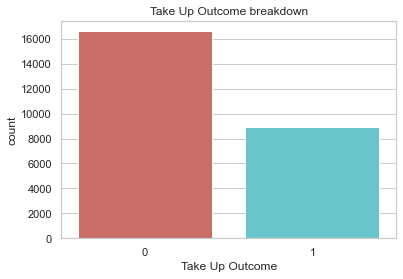

In [57]:
#Let's plot this breakdown
sns.countplot(x='Take Up Outcome', data=dt, palette= 'hls')
plt.title('Take Up Outcome breakdown')
plt.show()

Since not taking a policy is our outcome of interest and is represented by zero in the dataset, for the purpose of our analysis we are going to change these zeros in ones and vice versa

In [21]:
#Swapping values
dt['Take Up Outcome'] = dt['Take Up Outcome'].replace({0:1, 1:0})

In [23]:
#check the swapping
dt['Take Up Outcome'].value_counts()

0    16613
1     8886
Name: Take Up Outcome, dtype: int64

Since we are required to predict the likelihood and our target variable is binary we choose to use Logistic Regression for our analysis

### 5. Logistic Regression Model Fitting

**Logistic Regression** is a Machine Learning classification algorithm that is used to predict the probability of a binary categorical dependent variable, which contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.).  

Logistic Regression requires large sample sizes but might also face the **overfitting** problem, which occurs when the model learns the random extra noise in the data, and consequencely will be poor to generalise on unseen data. To overcome this problem we are going to randomly split the dataset in two sets, one for training the model and the other one to test and valide the model. The split will be 80% of the entire dataset for the training dataset and 20% for the test dataset.   

In [26]:
#Let's prepare the input data to be fitted into Scikit-Learn
X = dt[['Contract Status', 'Collection Count']]
X.head()

,Contract Status,Collection Count
0,1,6
1,1,7
2,1,2
3,0,11
4,1,0


In [28]:
#Same for the target variable
y = dt['Take Up Outcome']

#### 5.1 Training the Model

In [41]:
#Import, make instance and train the model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression()

####  5.2 Model Predictions

In [42]:
#Predictions on the test set
predictions = logreg.predict(X_test)

In [43]:
#Computing the accuracy on the test
score = logreg.score(X_test, y_test)
print(score)

0.8798039215686274


#### 5.3 Confusion Matrix   
A confusion matrix is a table that is used to describe the performance of a classification model on a set of test data for which true values are known and it is based on true and false positive or negative.   
* True Positive (TP) refers to the number of predictions where the classifier correctly predicts the positive class as positive.   
* False Positive (FP) is the number of predictions where the classifier incorrectly predicts the negative class as positive, it is also known as the Type I Error.   
* True Negative (TN) is the number of predictions where the classifier correctly predicts the negative class as negative.  
* False Negative (FN) is the number of predictions where the classifier incorrectly predicts the positive class as negative, it is also known as Type II Error

In [45]:
#Let's compute the confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[2761  555]
 [  58 1726]]


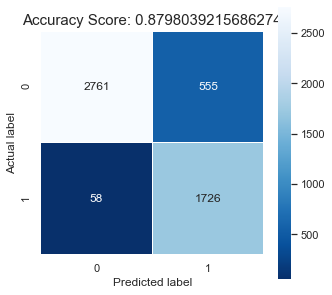

In [50]:
#Visualise the confusion matrix using the Seaborn package
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title='Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15);

The confusion matrix result is telling us that we have 2761 + 1726 = 4487 observations that we correctly classified and only 555 + 58 = 613 that we incorrectly classified or missed.   

Accuracy is not the only classification metric, we can also compute the precision, recall, F-measure and support.  

#### Precision, Recall, F-measure and Support   

`To quote Scikit Learn`

**Precision** is the ratio of TP / (TP + FP) where TP is the number of true positives and FP the number of false positives. The precision or `Specificity` is intuitevely the ability to correctly predict, it tells us how many of the correctly predicted cases actually turned out to be positive. Precision is a useful metric where FP is of a higher concern than FN.    

**Recall** is the ratio of TP / (TP + FN) where FN is the number of false negatives. Recall or `Sensitivity` is intuitively the ability to correctly detect, it tells us how many of the actual positive cases were the model able to predict correctly. Recall is a useful metric in cases where FN is of higher concern.   

**F-1 score** or `F-Measure score` can be interpreted as a weighted harmonic mean of the Precision and Recall, where F-score reaches its best value at 1 and worst score at 0. The F-beta score weights the recall more than the precission by a factor of beta, with beta = 1 meaning recall and precision are equally important.   

**Support** is the number of occurrence of each class in y_test.

In [52]:
#Precision and the other metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      3316
           1       0.76      0.97      0.85      1784

    accuracy                           0.88      5100
   macro avg       0.87      0.90      0.87      5100
weighted avg       0.90      0.88      0.88      5100



#### 5.4 Interpretation  

Based on the test set, our Logistic Regression model is able to predict at 88% of accuracy clients will not take up the policy. But this is not the full story as we would like to know about those who were not correctly identified, especially those false positives because in our case this means clients who were classified as not willing to pay their first monthly premium, but infact they will take up the policy. And the built model can perfectly identify that thanks to its high precision as can be seen in table above. On top of all the model has a very good F-1 score which means taking into account both precision and recall and produces a high F-1 score.  

Next step, let's look at the strength of our model meaning its prective power by using a tool called ROC curve.      

### 6. Receiver Operating Characteristic curve (ROC curve)  

A ROC curve is a graph that shows the performance of a classification model at all the possible thresholds. The optimum position for the ROC curve of a good model is towards the top corner where the specificity and sensitivity are at optimum levels. Let's construct the ROC curve of our Logistic Regression model and see its strength

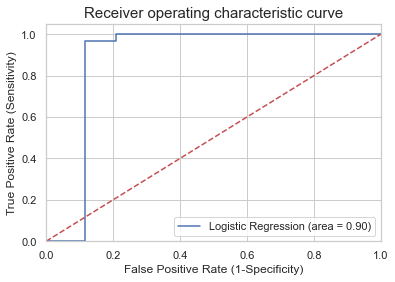

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)'% logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic curve', size=15)
plt.legend(loc='lower right')
plt.show()

#### 6.1 Area Under the Curve (AUC)   

The area under the ROC curve quantifies model classification accuracy, the higher the area, the greater the disparity between true and false positives, and the stronger the model in classifying members of the dataset.   
An area of 0.5, represent by the dot line on the graph above, corresponds to a model that performs no better than a random classification and a good classifier stays as far away from that line as possible as can be seen here, with an AUC=0.90 close to 1, testifying that our Logistic Regression model is strong.

## Part 2

### 1. Likelihood Calculation
**Calculate the likelihood of a client paying premium six month consecutively without lapsing or cancelling the contract**  

We can solve this problem in different ways, but if we are interested in obtaining the likelihood or the probability of the occurring of the event then the probability way seems to be intuive.  

Let X represent the event that a client pays his/her monthly premium. The probability of the event to occur or not, i.e. the probability of a client to pay or not to pay the monthly premium is equally distributed between the two parties (event and no event). So we can think of X following a binomial distribution with n=6 (six months) and p=0.5, then P(X=x) with n considered as  the number of trials, x the number of success (in our case we consider paying your monthly premium as a success), p is the probability of success and q=1-p is the probability of failure (not paying a premium). We assume that the occurrence of successifve events are independent i.e. paying one particular month does not depend to another month before or after. Under these conditions calculating the probability of paying the monthly premiums in 6 consecutive months, given that the first month was paid, can be done as follows: P(X=6).

In [58]:
from scipy.stats import binom_test

In [60]:
#Calculate P(X=6) using SciPy
binom_test(x=6, n=6, p=0.5, alternative='greater')

0.015625

**Therefore the likelihood of a client to pay his/her monthly premiums six months without lapsing or canceling the contract is 0.015625.**